**Architecture **

<img src="http://drive.google.com/uc?export=view&id=12JomC2IswVbNGdE0IIvPpUk8vPjP-MBQ"  alt="artchtecture">


---



(1) Importing dependency

In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import os

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


(2) Get Data

In [2]:
base_dir = 'data/'
data_dir = base_dir+'data_speech_commands_v0.02/'
 
train_txt = base_dir+'train_16words.txt'
val_txt = base_dir+'validation_16words.txt'
test_txt = base_dir+'test_16words.txt'

In [3]:
class_list = ['zero', 'one', 'two', 'three', 'four', 
              'five', 'six', 'seven', 'eight', 'nine', 
              'bed', 'bird', 'tree', 'cat', 'house',
              'dog']

class_dict = {_class:i for i, _class in enumerate(class_list)}

In [4]:
def load_wavs(filenames):
    first_wav, _ = librosa.load(filenames[0])
    wav_shape = first_wav.shape[0]
    x_data = [librosa.util.fix_length(librosa.load(filename)[0], wav_shape) 
              for filename in tqdm(filenames)]
    return np.asarray(x_data)
    
### If you have lack of memory, Use this
#     wav, _ = librosa.load(filenames[0])
#     wavs = np.zeros( (len(filenames), wav.shape[0]) )
#     for i, filename in enumerate(filenames):
#         wavs[i] = librosa.load(filename)[0][:]
#     return wavs

def make_x_data(filenames):
    x_data = load_wavs(filenames)
    x_data = np.reshape(x_data, (*x_data.shape, 1))
    return x_data
    
def extract_class_from_filename(filename):
    dirname = os.path.dirname(filename)
    class_name = dirname.split('/')[-1]
    return class_name

def make_y_data(filenames, y_dict):
    return np.asarray([to_categorical(y_dict[extract_class_from_filename(filename)], len(class_list)) 
                       for filename in filenames])

def make_xy_data(filenames, y_dict):
    x_data = make_x_data(filenames)
    y_data = make_y_data(filenames, y_dict)
    return x_data, y_data

In [5]:
print('Make train data.......')
with open(train_txt, 'r') as f:
    train_filename_list = [data_dir+line for line in f.read().splitlines()]
x_train, y_train = make_xy_data(train_filename_list, class_dict)
x_train, y_train = shuffle(x_train, y_train)

print('Make validation data.......')
with open(val_txt, 'r') as f:
    val_filename_list = [data_dir+line for line in f.read().splitlines()]
x_val, y_val = make_xy_data(val_filename_list, class_dict)
x_val, y_val = shuffle(x_train, y_train)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

Make train data.......



Make validation data.......



(40951, 22050, 1) (40951, 16) (40951, 22050, 1) (40951, 16)


(3) Create a sequential model

In [6]:
input_shape = x_train.shape[1:]
output_shape = len(class_list)
input_shape, output_shape

((22050, 1), 16)

In [8]:
### Define Parametric Softplus

# alpha * log(1 + exp(beta * x))
def ParametricSoftplus(alpha=0.2, beta=5.0):
  return lambda x: alpha * keras.activations.softplus(beta * x)

In [8]:
model=Sequential()

# 1st Convolutional Layer (conv1)
model.add(Conv1D (kernel_size=121, filters=48, strides=16, padding='same',
#                   input_shape=x_train.shape[1:]))
                  input_shape=input_shape))

model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool1)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 2nd Convolutional Layer (conv2)
model.add(Conv1D (kernel_size=25, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(BatchNormalization())

# Pooling (pool2)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 3rd Convolutional Layer (conv3)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 4rd Convolutional Layer (conv4)
model.add(Conv1D (kernel_size=9, filters=192, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# 5rd Convolutional Layer (conv5)
model.add(Conv1D (kernel_size=9, filters=128, padding='same'))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))

# Pooling (pool5)
model.add(MaxPooling1D(pool_size=9, strides=4, padding='same'))

# 1st Dense Layer (full6)
model.add(Flatten())
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5)) # Drop-out value is not specified in the paper

# 2nd Dense Layer (full7)
model.add(Dense(4096))
model.add(Activation(ParametricSoftplus(alpha=0.2, beta=0.5)))
model.add(Dropout(0.5))

# Output Layer (full8)
model.add(Dense(output_shape))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1379, 48)          5856      
_________________________________________________________________
activation_1 (Activation)    (None, 1379, 48)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1379, 48)          192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 345, 48)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 345, 128)          153728    
_________________________________________________________________
activation_2 (Activation)    (None, 345, 128)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 345, 128)          512       
__________

(4) Compile 

In [9]:
adam_with_params = keras.optimizers.Adam(lr=0.0001, beta_1=0.1, beta_2=0.999, 
                                         epsilon=1e-8)
model.compile(loss='categorical_crossentropy', optimizer=adam_with_params,
              metrics=['accuracy'])

(5) Train

In [5]:
model_path = '/users/lww/data/checkpoint/AlexNet_based_check_point/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [11]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=10000, validation_data=[x_val, y_val], 
                 shuffle=True, callbacks = [checkpointer, early_stopping])

Train on 40951 samples, validate on 40951 samples
Epoch 1/10000
40951/40951 [==============================] - 40s 981us/step - loss: 2.7514 - acc: 0.0784 - val_loss: 2.7322 - val_acc: 0.0724

Epoch 00001: val_loss improved from inf to 2.73216, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/01-2.7322.hdf5
Epoch 2/10000
40951/40951 [==============================] - 38s 929us/step - loss: 2.7485 - acc: 0.0758 - val_loss: 2.7343 - val_acc: 0.0774

Epoch 00002: val_loss did not improve from 2.73216
Epoch 3/10000
40951/40951 [==============================] - 38s 931us/step - loss: 2.5033 - acc: 0.1442 - val_loss: 2.2962 - val_acc: 0.2064

Epoch 00003: val_loss improved from 2.73216 to 2.29620, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/03-2.2962.hdf5
Epoch 4/10000
40951/40951 [==============================] - 38s 928us/step - loss: 2.2616 - acc: 0.2026 - val_loss: 2.2007 - val_acc: 0.2231

Epoch 00004: val_loss improved from 2.29620 to 2.20

40951/40951 [==============================] - 38s 919us/step - loss: 0.6872 - acc: 0.7712 - val_loss: 0.6310 - val_acc: 0.7941

Epoch 00030: val_loss improved from 0.63503 to 0.63101, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/30-0.6310.hdf5
Epoch 31/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.6689 - acc: 0.7767 - val_loss: 0.6201 - val_acc: 0.7965

Epoch 00031: val_loss improved from 0.63101 to 0.62008, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/31-0.6201.hdf5
Epoch 32/10000
40951/40951 [==============================] - 38s 919us/step - loss: 0.6532 - acc: 0.7829 - val_loss: 0.6385 - val_acc: 0.7864

Epoch 00032: val_loss did not improve from 0.62008
Epoch 33/10000
40951/40951 [==============================] - 38s 920us/step - loss: 0.6334 - acc: 0.7898 - val_loss: 0.5652 - val_acc: 0.8172

Epoch 00033: val_loss improved from 0.62008 to 0.56522, saving model to /users/lww/data/checkpoint/AlexNet_b

40951/40951 [==============================] - 39s 946us/step - loss: 0.3161 - acc: 0.8942 - val_loss: 0.2576 - val_acc: 0.9153

Epoch 00062: val_loss improved from 0.28119 to 0.25759, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/62-0.2576.hdf5
Epoch 63/10000
40951/40951 [==============================] - 39s 941us/step - loss: 0.3098 - acc: 0.8971 - val_loss: 0.2944 - val_acc: 0.9012

Epoch 00063: val_loss did not improve from 0.25759
Epoch 64/10000
40951/40951 [==============================] - 38s 936us/step - loss: 0.3069 - acc: 0.8960 - val_loss: 0.2481 - val_acc: 0.9187

Epoch 00064: val_loss improved from 0.25759 to 0.24808, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/64-0.2481.hdf5
Epoch 65/10000
40951/40951 [==============================] - 39s 946us/step - loss: 0.2953 - acc: 0.9003 - val_loss: 0.2370 - val_acc: 0.9222

Epoch 00065: val_loss improved from 0.24808 to 0.23696, saving model to /users/lww/data/checkpoint/AlexNet_b

Epoch 96/10000
40951/40951 [==============================] - 38s 939us/step - loss: 0.1531 - acc: 0.9472 - val_loss: 0.1156 - val_acc: 0.9618

Epoch 00096: val_loss did not improve from 0.10649
Epoch 97/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.1498 - acc: 0.9483 - val_loss: 0.1004 - val_acc: 0.9686

Epoch 00097: val_loss improved from 0.10649 to 0.10042, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/97-0.1004.hdf5
Epoch 98/10000
40951/40951 [==============================] - 39s 943us/step - loss: 0.1477 - acc: 0.9485 - val_loss: 0.1014 - val_acc: 0.9678

Epoch 00098: val_loss did not improve from 0.10042
Epoch 99/10000
40951/40951 [==============================] - 39s 945us/step - loss: 0.1413 - acc: 0.9504 - val_loss: 0.1070 - val_acc: 0.9659

Epoch 00099: val_loss did not improve from 0.10042
Epoch 100/10000
40951/40951 [==============================] - 39s 946us/step - loss: 0.1365 - acc: 0.9522 - val_loss: 0.1120 - val

40951/40951 [==============================] - 38s 929us/step - loss: 0.0485 - acc: 0.9838 - val_loss: 0.0193 - val_acc: 0.9951

Epoch 00169: val_loss did not improve from 0.01849
Epoch 170/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0466 - acc: 0.9851 - val_loss: 0.0187 - val_acc: 0.9952

Epoch 00170: val_loss did not improve from 0.01849
Epoch 171/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0416 - acc: 0.9871 - val_loss: 0.0168 - val_acc: 0.9959

Epoch 00171: val_loss improved from 0.01849 to 0.01680, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/171-0.0168.hdf5
Epoch 172/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0413 - acc: 0.9869 - val_loss: 0.0506 - val_acc: 0.9869

Epoch 00172: val_loss did not improve from 0.01680
Epoch 173/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0401 - acc: 0.9871 - val_loss: 0.0171 - val_acc: 0.995

40951/40951 [==============================] - 38s 930us/step - loss: 0.0244 - acc: 0.9928 - val_loss: 0.0083 - val_acc: 0.9978

Epoch 00245: val_loss did not improve from 0.00583
Epoch 246/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0213 - acc: 0.9936 - val_loss: 0.0109 - val_acc: 0.9970

Epoch 00246: val_loss did not improve from 0.00583
Epoch 247/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0190 - acc: 0.9937 - val_loss: 0.0072 - val_acc: 0.9982

Epoch 00247: val_loss did not improve from 0.00583
Epoch 248/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0254 - acc: 0.9923 - val_loss: 0.0060 - val_acc: 0.9986

Epoch 00248: val_loss did not improve from 0.00583
Epoch 249/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0212 - acc: 0.9936 - val_loss: 0.0159 - val_acc: 0.9968

Epoch 00249: val_loss did not improve from 0.00583
Epoch 250/10000
40951/40951 [=======


Epoch 00283: val_loss did not improve from 0.00366
Epoch 284/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0202 - acc: 0.9941 - val_loss: 0.0075 - val_acc: 0.9978

Epoch 00284: val_loss did not improve from 0.00366
Epoch 285/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0143 - acc: 0.9954 - val_loss: 0.0077 - val_acc: 0.9978

Epoch 00285: val_loss did not improve from 0.00366
Epoch 286/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0151 - acc: 0.9951 - val_loss: 0.0034 - val_acc: 0.9993

Epoch 00286: val_loss improved from 0.00366 to 0.00344, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/286-0.0034.hdf5
Epoch 287/10000
40951/40951 [==============================] - 38s 928us/step - loss: 0.0194 - acc: 0.9941 - val_loss: 0.0035 - val_acc: 0.9993

Epoch 00287: val_loss did not improve from 0.00344
Epoch 288/10000
40951/40951 [==============================] - 38s 929us/s


Epoch 00361: val_loss did not improve from 0.00185
Epoch 362/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0103 - acc: 0.9970 - val_loss: 0.0016 - val_acc: 0.9997

Epoch 00362: val_loss improved from 0.00185 to 0.00161, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/362-0.0016.hdf5
Epoch 363/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0094 - acc: 0.9972 - val_loss: 0.0037 - val_acc: 0.9991

Epoch 00363: val_loss did not improve from 0.00161
Epoch 364/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0104 - acc: 0.9970 - val_loss: 0.0445 - val_acc: 0.9882

Epoch 00364: val_loss did not improve from 0.00161
Epoch 365/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0115 - acc: 0.9968 - val_loss: 0.0021 - val_acc: 0.9996

Epoch 00365: val_loss did not improve from 0.00161
Epoch 366/10000
40951/40951 [==============================] - 38s 929us/s

40951/40951 [==============================] - 38s 930us/step - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0066 - val_acc: 0.9984

Epoch 00442: val_loss did not improve from 0.00114
Epoch 443/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0104 - acc: 0.9973 - val_loss: 0.0013 - val_acc: 0.9997

Epoch 00443: val_loss did not improve from 0.00114
Epoch 444/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0106 - acc: 0.9970 - val_loss: 0.0041 - val_acc: 0.9990

Epoch 00444: val_loss did not improve from 0.00114
Epoch 445/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0080 - acc: 0.9977 - val_loss: 0.0011 - val_acc: 0.9998

Epoch 00445: val_loss improved from 0.00114 to 0.00108, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/445-0.0011.hdf5
Epoch 446/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0121 - acc: 0.9966 - val_loss: 0.0064 - val_acc: 0.998

40951/40951 [==============================] - 38s 930us/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.0018 - val_acc: 0.9996

Epoch 00483: val_loss did not improve from 0.00105
Epoch 484/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0082 - acc: 0.9976 - val_loss: 0.0011 - val_acc: 0.9998

Epoch 00484: val_loss did not improve from 0.00105
Epoch 485/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0071 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9995

Epoch 00485: val_loss did not improve from 0.00105
Epoch 486/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0106 - acc: 0.9970 - val_loss: 0.0011 - val_acc: 0.9998

Epoch 00486: val_loss did not improve from 0.00105
Epoch 487/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0065 - acc: 0.9982 - val_loss: 9.8785e-04 - val_acc: 0.9998

Epoch 00487: val_loss improved from 0.00105 to 0.00099, saving model to /users/lww/

40951/40951 [==============================] - 38s 929us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00563: val_loss did not improve from 0.00082
Epoch 564/10000
40951/40951 [==============================] - 38s 931us/step - loss: 0.0046 - acc: 0.9986 - val_loss: 0.0020 - val_acc: 0.9996

Epoch 00564: val_loss did not improve from 0.00082
Epoch 565/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0053 - acc: 0.9985 - val_loss: 9.2591e-04 - val_acc: 0.9998

Epoch 00565: val_loss did not improve from 0.00082
Epoch 566/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0066 - acc: 0.9981 - val_loss: 8.3573e-04 - val_acc: 0.9998

Epoch 00566: val_loss did not improve from 0.00082
Epoch 567/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0072 - acc: 0.9979 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00567: val_loss did not improve from 0.00082
Epoch 568/10000
40951/40951 


Epoch 00604: val_loss did not improve from 0.00082
Epoch 605/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00605: val_loss did not improve from 0.00082
Epoch 606/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0052 - acc: 0.9984 - val_loss: 7.4466e-04 - val_acc: 0.9998

Epoch 00606: val_loss improved from 0.00082 to 0.00074, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/606-0.0007.hdf5
Epoch 607/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0060 - acc: 0.9982 - val_loss: 8.0579e-04 - val_acc: 0.9998

Epoch 00607: val_loss did not improve from 0.00074
Epoch 608/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0066 - acc: 0.9981 - val_loss: 8.1144e-04 - val_acc: 0.9998

Epoch 00608: val_loss did not improve from 0.00074
Epoch 609/10000
40951/40951 [==============================] -

40951/40951 [==============================] - 38s 929us/step - loss: 0.0057 - acc: 0.9984 - val_loss: 0.0013 - val_acc: 0.9998

Epoch 00685: val_loss did not improve from 0.00070
Epoch 686/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0052 - acc: 0.9984 - val_loss: 8.6068e-04 - val_acc: 0.9997

Epoch 00686: val_loss did not improve from 0.00070
Epoch 687/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0152 - acc: 0.9968 - val_loss: 0.0080 - val_acc: 0.9971

Epoch 00687: val_loss did not improve from 0.00070
Epoch 688/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0043 - acc: 0.9988 - val_loss: 7.5478e-04 - val_acc: 0.9998

Epoch 00688: val_loss did not improve from 0.00070
Epoch 689/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0055 - acc: 0.9985 - val_loss: 9.1828e-04 - val_acc: 0.9998

Epoch 00689: val_loss did not improve from 0.00070
Epoch 690/10000
40951/40

40951/40951 [==============================] - 38s 930us/step - loss: 0.0050 - acc: 0.9987 - val_loss: 0.0012 - val_acc: 0.9997

Epoch 00726: val_loss did not improve from 0.00070
Epoch 727/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 7.8205e-04 - val_acc: 0.9998

Epoch 00727: val_loss did not improve from 0.00070
Epoch 728/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0114 - acc: 0.9977 - val_loss: 9.7879e-04 - val_acc: 0.9997

Epoch 00728: val_loss did not improve from 0.00070
Epoch 729/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0058 - acc: 0.9987 - val_loss: 0.0016 - val_acc: 0.9997

Epoch 00729: val_loss did not improve from 0.00070
Epoch 730/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0056 - acc: 0.9988 - val_loss: 0.0012 - val_acc: 0.9997

Epoch 00730: val_loss did not improve from 0.00070
Epoch 731/10000
40951/40951 

40951/40951 [==============================] - 38s 929us/step - loss: 0.0041 - acc: 0.9987 - val_loss: 0.0034 - val_acc: 0.9993

Epoch 00767: val_loss did not improve from 0.00070
Epoch 768/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.0010 - val_acc: 0.9997

Epoch 00768: val_loss did not improve from 0.00070
Epoch 769/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0051 - acc: 0.9985 - val_loss: 9.1849e-04 - val_acc: 0.9998

Epoch 00769: val_loss did not improve from 0.00070
Epoch 770/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0052 - acc: 0.9985 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 00770: val_loss did not improve from 0.00070
Epoch 771/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 6.8480e-04 - val_acc: 0.9999

Epoch 00771: val_loss improved from 0.00070 to 0.00068, saving model to /users/

40951/40951 [==============================] - 38s 929us/step - loss: 0.0030 - acc: 0.9991 - val_loss: 6.3947e-04 - val_acc: 0.9999

Epoch 00848: val_loss did not improve from 0.00064
Epoch 849/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 6.6733e-04 - val_acc: 0.9999

Epoch 00849: val_loss did not improve from 0.00064
Epoch 850/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.0027 - val_acc: 0.9992

Epoch 00850: val_loss did not improve from 0.00064
Epoch 851/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0012 - val_acc: 0.9997

Epoch 00851: val_loss did not improve from 0.00064
Epoch 852/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0069 - acc: 0.9981 - val_loss: 7.2442e-04 - val_acc: 0.9999

Epoch 00852: val_loss did not improve from 0.00064
Epoch 853/10000
40951/40

40951/40951 [==============================] - 38s 929us/step - loss: 0.0070 - acc: 0.9984 - val_loss: 7.0808e-04 - val_acc: 0.9999

Epoch 00929: val_loss did not improve from 0.00063
Epoch 930/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0031 - acc: 0.9991 - val_loss: 0.0094 - val_acc: 0.9970

Epoch 00930: val_loss did not improve from 0.00063
Epoch 931/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0026 - acc: 0.9991 - val_loss: 6.8840e-04 - val_acc: 0.9999

Epoch 00931: val_loss did not improve from 0.00063
Epoch 932/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0040 - acc: 0.9990 - val_loss: 9.1762e-04 - val_acc: 0.9999

Epoch 00932: val_loss did not improve from 0.00063
Epoch 933/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.0015 - val_acc: 0.9997

Epoch 00933: val_loss did not improve from 0.00063
Epoch 934/10000
40951/40

40951/40951 [==============================] - 38s 929us/step - loss: 0.0074 - acc: 0.9980 - val_loss: 6.2244e-04 - val_acc: 0.9999

Epoch 01010: val_loss did not improve from 0.00060
Epoch 1011/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0059 - acc: 0.9984 - val_loss: 6.9197e-04 - val_acc: 0.9998

Epoch 01011: val_loss did not improve from 0.00060
Epoch 1012/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 7.2356e-04 - val_acc: 0.9998

Epoch 01012: val_loss did not improve from 0.00060
Epoch 1013/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0022 - acc: 0.9994 - val_loss: 6.3347e-04 - val_acc: 0.9999

Epoch 01013: val_loss did not improve from 0.00060
Epoch 1014/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0032 - acc: 0.9991 - val_loss: 6.7057e-04 - val_acc: 0.9999

Epoch 01014: val_loss did not improve from 0.00060
Epoch 1015/1

40951/40951 [==============================] - 38s 930us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 9.1269e-04 - val_acc: 0.9998

Epoch 01050: val_loss did not improve from 0.00060
Epoch 1051/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0047 - acc: 0.9986 - val_loss: 6.8282e-04 - val_acc: 0.9999

Epoch 01051: val_loss did not improve from 0.00060
Epoch 1052/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0037 - acc: 0.9988 - val_loss: 6.4661e-04 - val_acc: 0.9999

Epoch 01052: val_loss did not improve from 0.00060
Epoch 1053/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0021 - acc: 0.9994 - val_loss: 7.2320e-04 - val_acc: 0.9998

Epoch 01053: val_loss did not improve from 0.00060
Epoch 1054/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0032 - acc: 0.9989 - val_loss: 6.3560e-04 - val_acc: 0.9999

Epoch 01054: val_loss did not improve from 0.00060
Epoch 1055/1


Epoch 01090: val_loss did not improve from 0.00060
Epoch 1091/10000
40951/40951 [==============================] - 38s 936us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 6.0481e-04 - val_acc: 0.9999

Epoch 01091: val_loss did not improve from 0.00060
Epoch 1092/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0056 - acc: 0.9985 - val_loss: 6.2270e-04 - val_acc: 0.9999

Epoch 01092: val_loss did not improve from 0.00060
Epoch 1093/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 5.8714e-04 - val_acc: 0.9999

Epoch 01093: val_loss improved from 0.00060 to 0.00059, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/1093-0.0006.hdf5
Epoch 1094/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0010 - val_acc: 0.9998

Epoch 01094: val_loss did not improve from 0.00059
Epoch 1095/10000
40951/40951 [===========================

40951/40951 [==============================] - 38s 921us/step - loss: 0.0045 - acc: 0.9988 - val_loss: 5.8918e-04 - val_acc: 0.9999

Epoch 01130: val_loss did not improve from 0.00058
Epoch 1131/10000
40951/40951 [==============================] - 38s 921us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 5.6497e-04 - val_acc: 0.9999

Epoch 01131: val_loss improved from 0.00058 to 0.00056, saving model to /users/lww/data/checkpoint/AlexNet_based_check_point/1131-0.0006.hdf5
Epoch 1132/10000
40951/40951 [==============================] - 38s 937us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 6.5452e-04 - val_acc: 0.9999

Epoch 01132: val_loss did not improve from 0.00056
Epoch 1133/10000
40951/40951 [==============================] - 38s 933us/step - loss: 0.0028 - acc: 0.9993 - val_loss: 6.1347e-04 - val_acc: 0.9999

Epoch 01133: val_loss did not improve from 0.00056
Epoch 1134/10000
40951/40951 [==============================] - 38s 936us/step - loss: 0.0043 - acc: 0.9990 - val_loss: 6.

40951/40951 [==============================] - 38s 931us/step - loss: 0.0046 - acc: 0.9990 - val_loss: 8.8428e-04 - val_acc: 0.9998

Epoch 01170: val_loss did not improve from 0.00056
Epoch 1171/10000
40951/40951 [==============================] - 38s 931us/step - loss: 0.0032 - acc: 0.9990 - val_loss: 6.2050e-04 - val_acc: 0.9999

Epoch 01171: val_loss did not improve from 0.00056
Epoch 1172/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0042 - acc: 0.9989 - val_loss: 9.8469e-04 - val_acc: 0.9997

Epoch 01172: val_loss did not improve from 0.00056
Epoch 1173/10000
40951/40951 [==============================] - 38s 931us/step - loss: 0.0052 - acc: 0.9989 - val_loss: 7.5791e-04 - val_acc: 0.9999

Epoch 01173: val_loss did not improve from 0.00056
Epoch 1174/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0033 - acc: 0.9991 - val_loss: 8.2312e-04 - val_acc: 0.9998

Epoch 01174: val_loss did not improve from 0.00056
Epoch 1175/1

40951/40951 [==============================] - 38s 932us/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.0031 - val_acc: 0.9990

Epoch 01211: val_loss did not improve from 0.00056
Epoch 1212/10000
40951/40951 [==============================] - 38s 931us/step - loss: 0.0041 - acc: 0.9990 - val_loss: 5.8595e-04 - val_acc: 0.9999

Epoch 01212: val_loss did not improve from 0.00056
Epoch 1213/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0020 - acc: 0.9995 - val_loss: 6.6693e-04 - val_acc: 0.9998

Epoch 01213: val_loss did not improve from 0.00056
Epoch 1214/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 8.6369e-04 - val_acc: 0.9998

Epoch 01214: val_loss did not improve from 0.00056
Epoch 1215/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0019 - val_acc: 0.9996

Epoch 01215: val_loss did not improve from 0.00056
Epoch 1216/10000
409

40951/40951 [==============================] - 38s 932us/step - loss: 0.0043 - acc: 0.9989 - val_loss: 5.8032e-04 - val_acc: 0.9999

Epoch 01252: val_loss did not improve from 0.00056
Epoch 1253/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0070 - acc: 0.9985 - val_loss: 8.3045e-04 - val_acc: 0.9998

Epoch 01253: val_loss did not improve from 0.00056
Epoch 1254/10000
40951/40951 [==============================] - 38s 935us/step - loss: 0.0029 - acc: 0.9992 - val_loss: 5.8865e-04 - val_acc: 0.9999

Epoch 01254: val_loss did not improve from 0.00056
Epoch 1255/10000
40951/40951 [==============================] - 38s 934us/step - loss: 0.0018 - acc: 0.9995 - val_loss: 6.2434e-04 - val_acc: 0.9999

Epoch 01255: val_loss did not improve from 0.00056
Epoch 1256/10000
40951/40951 [==============================] - 38s 932us/step - loss: 0.0015 - acc: 0.9996 - val_loss: 5.8928e-04 - val_acc: 0.9999

Epoch 01256: val_loss did not improve from 0.00056
Epoch 1257/1


Epoch 01291: val_loss did not improve from 0.00056
Epoch 1292/10000
40951/40951 [==============================] - 41s 992us/step - loss: 0.0032 - acc: 0.9992 - val_loss: 6.9727e-04 - val_acc: 0.9998

Epoch 01292: val_loss did not improve from 0.00056
Epoch 1293/10000
40951/40951 [==============================] - 41s 1ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 5.9884e-04 - val_acc: 0.9999

Epoch 01293: val_loss did not improve from 0.00056
Epoch 1294/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.0017 - val_acc: 0.9996

Epoch 01294: val_loss did not improve from 0.00056
Epoch 1295/10000
40951/40951 [==============================] - 38s 938us/step - loss: 0.0062 - acc: 0.9986 - val_loss: 8.4531e-04 - val_acc: 0.9998

Epoch 01295: val_loss did not improve from 0.00056
Epoch 1296/10000
40951/40951 [==============================] - 38s 935us/step - loss: 0.0030 - acc: 0.9992 - val_loss: 6.7211e-04 - val_acc: 0.9999



40951/40951 [==============================] - 38s 929us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 8.8816e-04 - val_acc: 0.9998

Epoch 01372: val_loss did not improve from 0.00055
Epoch 1373/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 9.3119e-04 - val_acc: 0.9998

Epoch 01373: val_loss did not improve from 0.00055
Epoch 1374/10000
40951/40951 [==============================] - 38s 928us/step - loss: 0.0030 - acc: 0.9992 - val_loss: 6.0627e-04 - val_acc: 0.9999

Epoch 01374: val_loss did not improve from 0.00055
Epoch 1375/10000
40951/40951 [==============================] - 38s 937us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 6.4537e-04 - val_acc: 0.9998

Epoch 01375: val_loss did not improve from 0.00055
Epoch 1376/10000
40951/40951 [==============================] - 38s 929us/step - loss: 0.0029 - acc: 0.9992 - val_loss: 6.8979e-04 - val_acc: 0.9999

Epoch 01376: val_loss did not improve from 0.00055
Epoch 1377/1

40951/40951 [==============================] - 38s 920us/step - loss: 0.0042 - acc: 0.9989 - val_loss: 6.0037e-04 - val_acc: 0.9999

Epoch 01453: val_loss did not improve from 0.00054
Epoch 1454/10000
40951/40951 [==============================] - 38s 920us/step - loss: 0.0027 - acc: 0.9992 - val_loss: 5.8503e-04 - val_acc: 0.9999

Epoch 01454: val_loss did not improve from 0.00054
Epoch 1455/10000
40951/40951 [==============================] - 38s 920us/step - loss: 0.0023 - acc: 0.9995 - val_loss: 5.6697e-04 - val_acc: 0.9999

Epoch 01455: val_loss did not improve from 0.00054
Epoch 1456/10000
40951/40951 [==============================] - 38s 920us/step - loss: 0.0027 - acc: 0.9993 - val_loss: 5.7090e-04 - val_acc: 0.9999

Epoch 01456: val_loss did not improve from 0.00054
Epoch 1457/10000
40951/40951 [==============================] - 38s 920us/step - loss: 0.0023 - acc: 0.9994 - val_loss: 6.1977e-04 - val_acc: 0.9999

Epoch 01457: val_loss did not improve from 0.00054
Epoch 1458/1

40951/40951 [==============================] - 39s 946us/step - loss: 0.0029 - acc: 0.9992 - val_loss: 5.5189e-04 - val_acc: 0.9999

Epoch 01494: val_loss did not improve from 0.00054
Epoch 1495/10000
40951/40951 [==============================] - 38s 930us/step - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 0.9995

Epoch 01495: val_loss did not improve from 0.00054
Epoch 1496/10000
40951/40951 [==============================] - 38s 937us/step - loss: 0.0019 - acc: 0.9995 - val_loss: 5.5237e-04 - val_acc: 0.9999

Epoch 01496: val_loss did not improve from 0.00054
Epoch 1497/10000
40951/40951 [==============================] - 38s 936us/step - loss: 0.0033 - acc: 0.9994 - val_loss: 0.0123 - val_acc: 0.9982

Epoch 01497: val_loss did not improve from 0.00054
Epoch 1498/10000
40951/40951 [==============================] - 38s 925us/step - loss: 0.0037 - acc: 0.9990 - val_loss: 6.3321e-04 - val_acc: 0.9999

Epoch 01498: val_loss did not improve from 0.00054
Epoch 1499/10000
409

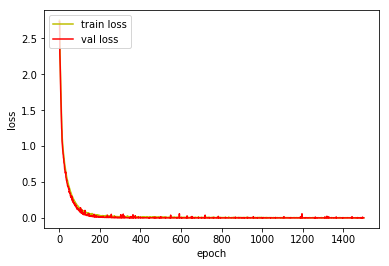

In [12]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper left')

plt.show()

(6) Test

In [6]:
print('Make test data.......')
with open(test_txt, 'r') as f:
    test_filename_list = [data_dir+line for line in f.read().splitlines()]
x_test, y_test = make_xy_data(test_filename_list, class_dict)
x_test, y_test = shuffle(x_test, y_test)

Make test data.......


In [9]:
model = load_model(model_path+'999-0.0006.hdf5',custom_objects={'<lambda>': ParametricSoftplus(0.2, 0.5)})

In [10]:
[loss, accuracy] = model.evaluate(x_test, y_test)
print('Loss:', loss, 'Accuracy:', accuracy)

5297/5297 [==============================] - 2s 365us/step
Loss: 0.9083024146740707 Accuracy: 0.9018312252330762


In [24]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

ValueError: Target is multilabel-indicator but average='binary'. Please choose another average setting.

In [ ]:
%timeit -n 5 -r 5 model.predict(x_test)